# Notebook exploring High PSF Flux/ Aperture Flux ratios

In [11]:
# Basic imports
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import importlib
import pandas as pd
from IPython.display import Image, display

from astropy.coordinates import SkyCoord
import astropy.units as u

import lsst.geom
import lsst.daf.butler as dafButler
from lsst.ap.association import UnpackApdbFlags, TransformDiaSourceCatalogConfig
#sys.path.append('/home/s/smart/u/code/analysis_ap/python/lsst/analysis/ap')
from lsst.analysis.ap import legacyApdbUtils as utils
from lsst.analysis.ap import legacyPlotUtils as plac

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

importlib.reload(utils)

bandList = ['i', 'z', 'y']
colorList = ['C2', 'C3', 'C5', 'k']
import lsst.afw.display as afwDisplay
from IPython.display import IFrame
import matplotlib.pyplot as plt
import numpy as np
import scipy.ndimage
import gc


afwDisplay.setDefaultBackend('matplotlib') 

In [12]:
class PathManager:
    """Manage paths to local files, chunked directories, and s3 buckets.
    Parameters
    ----------
    root : `str`
        Root file path to manage.
    chunk_size : `int`, optional
        How many files per directory?
    """
    def __init__(self, root, chunk_size=None):
        self._root = root
        if chunk_size is not None and chunk_size % 10 != 0:
            raise RuntimeError(f"PathManager file chunking must be a multiple of 10, got {chunk_size}.")
        self._chunk_size = chunk_size

    def __call__(self, id=None, filename=None):
        """Return the full path to this diaSourceId cutout.
        Parameters
        ----------
        id : `int`
            Description
        filename : None, optional
            Description
        Returns
        -------
        TYPE
            Description
        """
        def chunker(id, size):
            return (id // size)*size

        if id is not None:
            if self._chunk_size is not None:
                return os.path.join(self._root, f"images/{chunker(id, self._chunk_size)}/{id}.png")
            else:
                return os.path.join(self._root, f"images/{id}.png")
        elif filename is not None:
            return os.path.join(self._root, filename)

In [19]:
# This file is part of analysis_ap.
#
# Developed for the LSST Data Management System.
# This product includes software developed by the LSST Project
# (https://www.lsst.org).
# See the COPYRIGHT file at the top-level directory of this distribution
# for details of code ownership.
#
# This program is free software: you can redistribute it and/or modify
# it under the terms of the GNU General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.
#
# This program is distributed in the hope that it will be useful,
# but WITHOUT ANY WARRANTY; without even the implied warranty of
# MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
# GNU General Public License for more details.
#
# You should have received a copy of the GNU General Public License
# along with this program.  If not, see <https://www.gnu.org/licenses/>.

__all__ = ["make_simbad_link"]

from IPython.display import display, Markdown
import astropy.coordinates as coord
from astroquery.simbad import Simbad
import astropy.units as u


def make_simbad_link(ra, dec, radius_arcsec=3.0):
    """Search Simbad for associated sources within a 3 arcsecond region.

    Parameters
    ----------
    ra : 'float'
        Ra from source.
        
    dec : 'float'
        Dec from source.

    radius_arcsec : 'float'
        Search radius submitted to Simbad in arcseconds.
        Default radius is 3 arcseconds.

    Returns
    -------
    results_table : `astropy.table.table.Table`
        A table of Simbad search results.
    """

    search_results = f"http://simbad.cds.unistra.fr/simbad/sim-coo?Coord={ra}+{dec}" \
                     f"&CooFrame=FK5&CooEpoch=2000&CooEqui=2000&CooDefinedFrames=none&Radius=" \
                     f"{radius_arcsec}&Radius.unit=arcsec&submit=submit+query&CoordList="
    display(Markdown(f"[Link to Simbad search]({search_results})"))

    source_coords = coord.SkyCoord(ra, dec, frame="icrs", unit=(u.deg, u.deg))
    customSimbad=Simbad()
    customSimbad.TIMEOUT = 600
    customSimbad.add_votable_fields("otype(V)")
    results_table = customSimbad.query_region(
        source_coords, radius=radius_arcsec*u.arcsecond
        )

    if results_table is not None:

        return results_table

    else:
        print(f"No matched sources within {radius_arcsec} arcseconds.")

        return None


In [13]:
!eups list -s | grep analysis_ap

analysis_ap           LOCAL:/sdf/group/rubin/u/parejko/scratch/analysis_ap-apdb 	setup


In [29]:
path_manager = PathManager("/sdf/group/rubin/u/parejko/scratch/cutouts", chunk_size=10000)

In [42]:
collection="u/elhoward/DM-35285/hsc-output-collection"
butler = lsst.daf.butler.Butler("/repo/main", collections=collection)

apdbQuery = apdb.ApdbPostgresQuery("elhoward_dm35285_hsc_appipewithfakes", butler=butler, instrument="HSC")
sources = apdbQuery.load_sources()
objects = apdbQuery.load_objects()

In [31]:
# Unpacked flags for the sources

flag_map = os.path.join(lsst.utils.getPackageDir("ap_association"), "data/association-flag-map.yaml")
unpacker = UnpackApdbFlags(flag_map, "DiaSource")
flags = unpacker.unpack(sources["flags"], "flags")

In [32]:
noCenterCr=flags[np.where(flags["base_PixelFlags_flag_crCenter"] == False)]
noCenterCrSources=sources.iloc[np.where(flags["base_PixelFlags_flag_crCenter"] == False)]

In [33]:
noCr=noCenterCr[np.where(noCenterCr["base_PixelFlags_flag_cr"]  == False)]
noCrSources=noCenterCrSources.iloc[np.where(noCenterCr["base_PixelFlags_flag_cr"] == False)]

In [34]:
good=noCr[np.where(noCr["base_PixelFlags_flag_bad"]  == False)]
goodSources=noCrSources.iloc[np.where(noCr["base_PixelFlags_flag_bad"]  == False)]

In [35]:
loc=np.where(goodSources['apFlux']/goodSources['psFlux'] >= 10.0)
fluxCompSources=goodSources.iloc[loc]

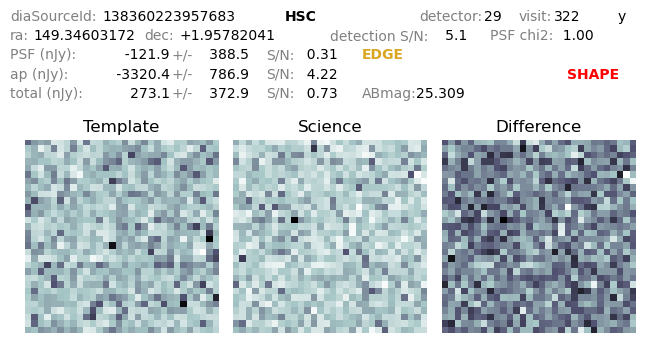

[Link to Simbad search](http://simbad.cds.unistra.fr/simbad/sim-coo?Coord=149.34603171830543+1.957820410049106&CooFrame=FK5&CooEpoch=2000&CooEqui=2000&CooDefinedFrames=none&Radius=3.0&Radius.unit=arcsec&submit=submit+query&CoordList=)

No matched sources within 3.0 arcseconds.
nan


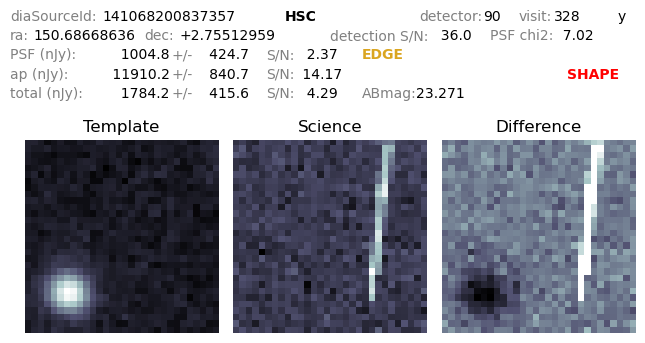

[Link to Simbad search](http://simbad.cds.unistra.fr/simbad/sim-coo?Coord=150.6866863649811+2.7551295908216695&CooFrame=FK5&CooEpoch=2000&CooEqui=2000&CooDefinedFrames=none&Radius=3.0&Radius.unit=arcsec&submit=submit+query&CoordList=)

No matched sources within 3.0 arcseconds.
nan


In [36]:
paths=fluxCompSources['diaSourceId']

for index, source in fluxCompSources[0:200].iterrows():
    #if source['snr'] >= 8.0 and source['isDipole'] == False:
    if source['isDipole'] == False:
        single_path = path_manager(source['diaSourceId'])
        display(Image(single_path))
        make_simbad_link(source['ra'], source['decl'])
        print(source['trailLength'])

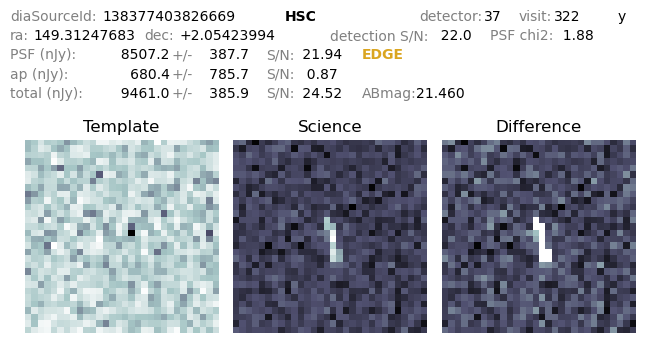

[Link to Simbad search](http://simbad.cds.unistra.fr/simbad/sim-coo?Coord=149.31247682828334+2.054239944765464&CooFrame=FK5&CooEpoch=2000&CooEqui=2000&CooDefinedFrames=none&Radius=3.0&Radius.unit=arcsec&submit=submit+query&CoordList=)

No matched sources within 3.0 arcseconds.
0.8110783999513879


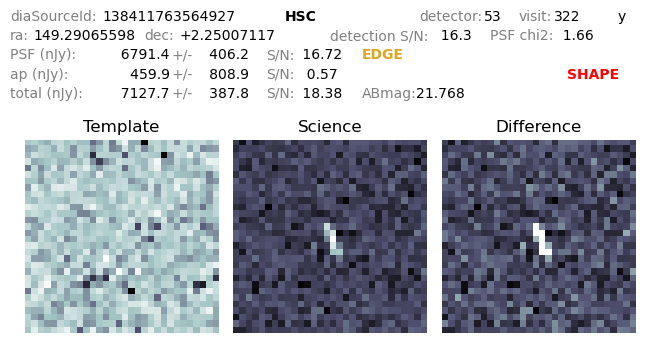

[Link to Simbad search](http://simbad.cds.unistra.fr/simbad/sim-coo?Coord=149.29065597747575+2.250071173334672&CooFrame=FK5&CooEpoch=2000&CooEqui=2000&CooDefinedFrames=none&Radius=3.0&Radius.unit=arcsec&submit=submit+query&CoordList=)

No matched sources within 3.0 arcseconds.
nan


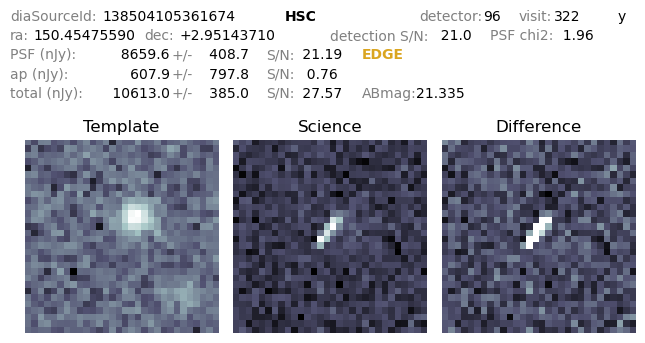

[Link to Simbad search](http://simbad.cds.unistra.fr/simbad/sim-coo?Coord=150.45475589763964+2.9514370989120904&CooFrame=FK5&CooEpoch=2000&CooEqui=2000&CooDefinedFrames=none&Radius=3.0&Radius.unit=arcsec&submit=submit+query&CoordList=)

No matched sources within 3.0 arcseconds.
0.8214947103599465


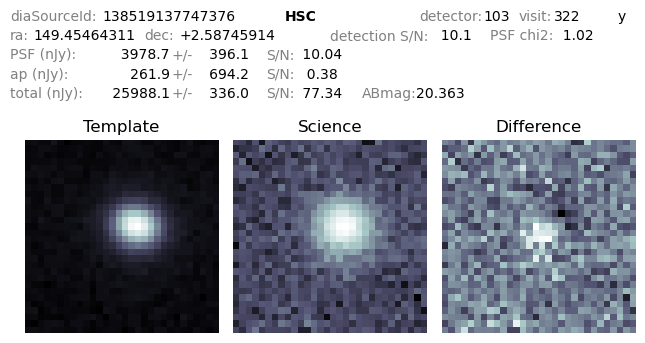

[Link to Simbad search](http://simbad.cds.unistra.fr/simbad/sim-coo?Coord=149.45464311071086+2.5874591444974797&CooFrame=FK5&CooEpoch=2000&CooEqui=2000&CooDefinedFrames=none&Radius=3.0&Radius.unit=arcsec&submit=submit+query&CoordList=)

0.659328386245153


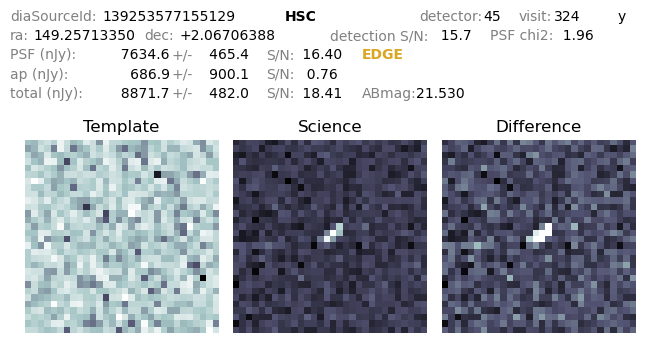

[Link to Simbad search](http://simbad.cds.unistra.fr/simbad/sim-coo?Coord=149.25713350292898+2.0670638763272318&CooFrame=FK5&CooEpoch=2000&CooEqui=2000&CooDefinedFrames=none&Radius=3.0&Radius.unit=arcsec&submit=submit+query&CoordList=)

No matched sources within 3.0 arcseconds.
0.5637695836936676


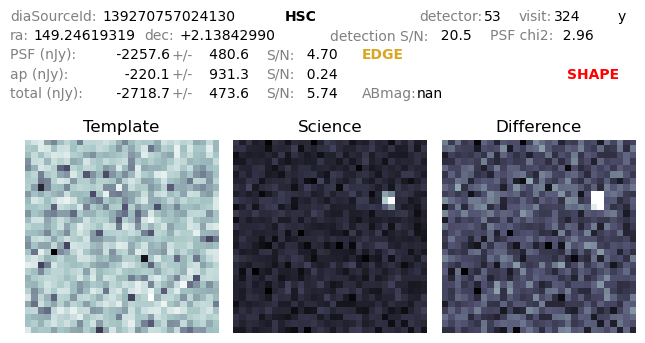

[Link to Simbad search](http://simbad.cds.unistra.fr/simbad/sim-coo?Coord=149.24619318564098+2.13842989598817&CooFrame=FK5&CooEpoch=2000&CooEqui=2000&CooDefinedFrames=none&Radius=3.0&Radius.unit=arcsec&submit=submit+query&CoordList=)

No matched sources within 3.0 arcseconds.
nan


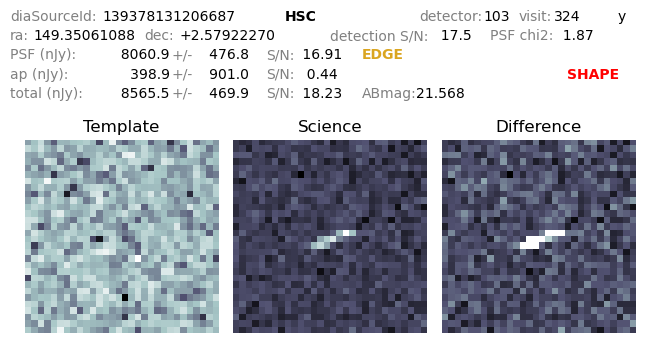

[Link to Simbad search](http://simbad.cds.unistra.fr/simbad/sim-coo?Coord=149.35061087821782+2.579222697803716&CooFrame=FK5&CooEpoch=2000&CooEqui=2000&CooDefinedFrames=none&Radius=3.0&Radius.unit=arcsec&submit=submit+query&CoordList=)

No matched sources within 3.0 arcseconds.
nan


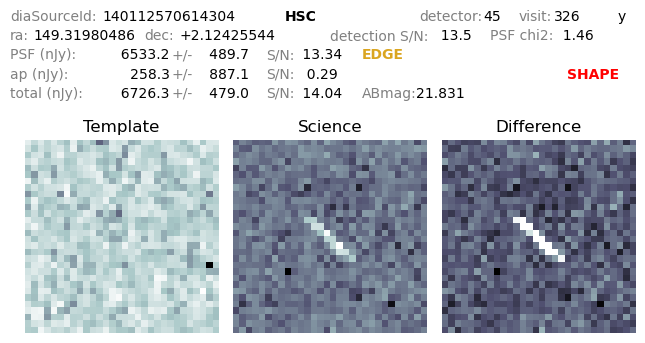

[Link to Simbad search](http://simbad.cds.unistra.fr/simbad/sim-coo?Coord=149.3198048575075+2.1242554367376494&CooFrame=FK5&CooEpoch=2000&CooEqui=2000&CooDefinedFrames=none&Radius=3.0&Radius.unit=arcsec&submit=submit+query&CoordList=)

No matched sources within 3.0 arcseconds.
1.4748068765820486


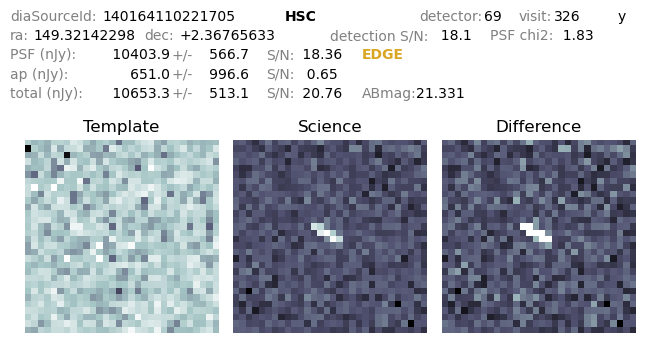

[Link to Simbad search](http://simbad.cds.unistra.fr/simbad/sim-coo?Coord=149.32142297596533+2.3676563259539147&CooFrame=FK5&CooEpoch=2000&CooEqui=2000&CooDefinedFrames=none&Radius=3.0&Radius.unit=arcsec&submit=submit+query&CoordList=)

No matched sources within 3.0 arcseconds.
0.7413078882389946


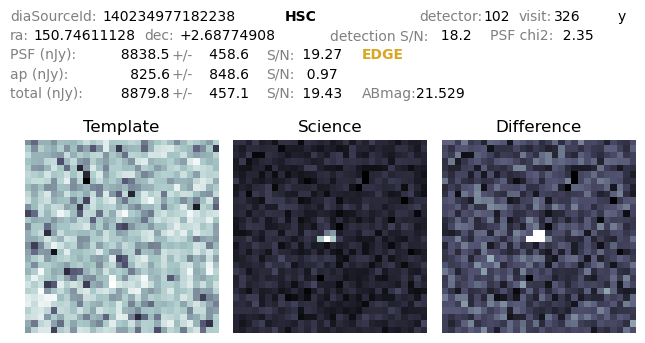

[Link to Simbad search](http://simbad.cds.unistra.fr/simbad/sim-coo?Coord=150.7461112845053+2.6877490789088667&CooFrame=FK5&CooEpoch=2000&CooEqui=2000&CooDefinedFrames=none&Radius=3.0&Radius.unit=arcsec&submit=submit+query&CoordList=)

0.32663937521836744


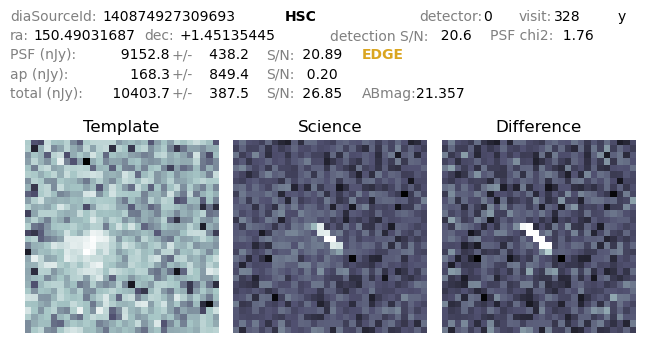

[Link to Simbad search](http://simbad.cds.unistra.fr/simbad/sim-coo?Coord=150.49031687071448+1.451354446355758&CooFrame=FK5&CooEpoch=2000&CooEqui=2000&CooDefinedFrames=none&Radius=3.0&Radius.unit=arcsec&submit=submit+query&CoordList=)

No matched sources within 3.0 arcseconds.
0.7500475660527872


In [38]:
loc=np.where(goodSources['psFlux']/goodSources['apFlux'] >= 10.0)
fluxCompSources=goodSources.iloc[loc]

paths=fluxCompSources['diaSourceId']

for index, source in fluxCompSources[0:200].iterrows():
    if source['snr'] >= 8.0 and source['isDipole'] == False:
        if source['isDipole'] == False:
            single_path = path_manager(source['diaSourceId'])
            display(Image(single_path))
            make_simbad_link(source['ra'], source['decl'])
            print(source['trailLength'])

In [46]:
import lsst.afw.display as afwDisplay

In [47]:
display = afwDisplay.getDisplay()
calexp = butler.get('calexp', visit=328, detector=0, collections=collection, instrument='HSC')

In [48]:
display.mtv(calexp)